# Core Imports

In [51]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole

import pubchempy as pcp

DIM    = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Static Paths
RAW_DATA_DIR  = Path('raw_monomer_data')
PROC_DATA_DIR = Path('processed_monomer_data')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

# Inspecting and filtering expanded dataset

In [52]:
from polymerist.monomers import specification

input_data_path = RAW_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
df = pd.read_csv(input_data_path)

## Filter by number of monomer fragments in monomer SMILES

### Verify that the num_monomers fields is accurate

In [53]:
num_mols_in_smiles = lambda smiles : len(
    Chem.GetMolFrags(
        Chem.MolFromSmiles(smiles)
    )
)

reported_num_monomers = df['num_monomers']
actual_num_monomers   = df.apply(lambda row : num_mols_in_smiles(row['smiles_monomer']), axis=1)

assert( (reported_num_monomers == actual_num_monomers).all() )

### Sort by polymerization mechanism and #monomers, obtain respective counts and colors

In [54]:
from polymerist.graphics import plotutils

# keys = ['num_monomers', 'mechanism']
keys = ['mechanism', 'num_monomers']

df_grouper = df.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

In [55]:
counts = df_grouper.size().to_dict()
cdict, carr = plotutils.label_discrete_cmap(
    cmap=plt.get_cmap('tab10'),
    color_names=df.mechanism.unique(),
    hues_per_color=1
)

In [56]:
colors = []
plot_counts = {}
for (mech, num_mono), count_val in counts.items():
    plot_counts[f'{mech}\n{num_mono} mono'] = count_val
    colors.append(cdict[mech])

### Plot Histogram by number of monomers and mechanism

Text(0.5, 1.0, 'Number of SMILES by mechanism & num_monomers (466 total)')

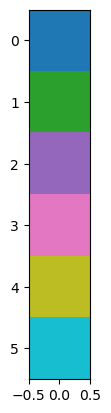

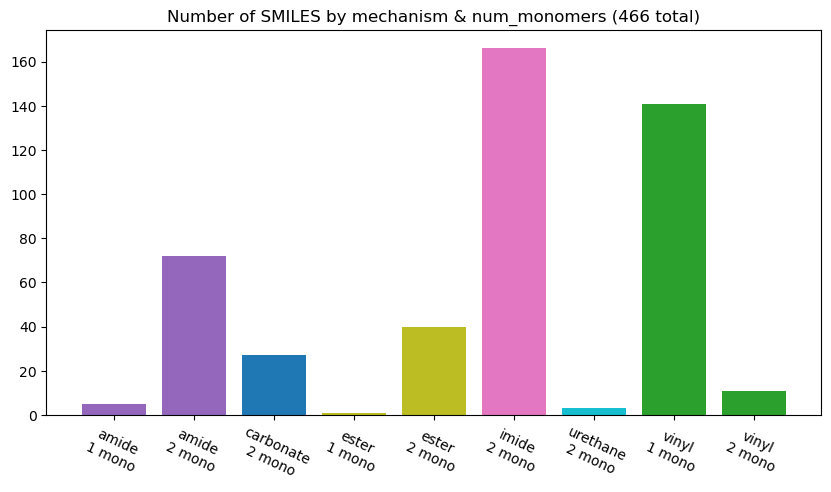

In [57]:
plt.imshow(carr)

plotutils.presize_subplots(1, 1, scale=10, elongation=1/2)

plt.bar(plot_counts.keys(), plot_counts.values(), color=colors)
plt.xticks(np.arange(len(counts))+0, rotation=-25)

plt.title(f'Number of SMILES by {" & ".join(keys)} ({len(df)} total)')

In [58]:
df = df[df['num_monomers'] == 2]
display(df)

,smiles_monomer,smiles_polymer_DP2,smiles_polymer_DP3,smiles_polymer_DP6,smiles_polymer_DP18,num_monomers,mechanism,Glass_Transition,Melt_Temp,Cp_solid_slope,...,log10_ElongBreak,YoungMod,Tensile_Strength,Density,log10_Permeability_CH4,log10_Permeability_CO2,log10_Permeability_N2,log10_Permeability_O2,log10_Permeability_H2,log10_Permeability_H2O
0,O=C(Cl)Cl.Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(...,O=C(Cl)Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(F)F...,O=C(Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(F)F)cc...,O=C(Cl)Oc1ccc(C(c2ccc(OC(=O)Oc3ccc(C(c4ccc(OC(...,O=C(Cl)Oc1ccc(C(c2ccc(OC(=O)Oc3ccc(C(c4ccc(OC(...,2,carbonate,176.00,NaN,NaN,...,NaN,NaN,NaN,1.479,0.017759,1.380211,0.225687,0.838849,NaN,NaN
5,O=C(O)c1cccc(C(=O)O)c1.Nc1ccc(-c2ccc(Oc3ccc(Oc...,Nc1ccc(-c2cc(Oc3ccc(Oc4ccc(-c5ccc(NC(=O)c6cccc...,Nc1ccc(-c2ccc(Oc3ccc(Oc4cc(-c5ccc(NC(=O)c6cccc...,Nc1ccc(-c2cc(Oc3ccc(Oc4ccc(-c5ccc(NC(=O)c6cccc...,Nc1ccc(-c2cc(Oc3ccc(Oc4ccc(-c5ccc(NC(=O)c6cccc...,2,amide,243.00,NaN,NaN,...,1.316180,NaN,NaN,1.360,-0.397940,1.114277,-0.275724,0.514548,NaN,NaN
6,O=C(Cl)Cl.Cc1cc(C(C)(C)c2cc(C)c(O)c(C)c2)cc(C)c1O,Cc1cc(C(C)(C)c2cc(C)c(OC(=O)Cl)c(C)c2)cc(C)c1O,Cc1cc(C(C)(C)c2cc(C)c(OC(=O)Cl)c(C)c2)cc(C)c1O...,Cc1cc(C(C)(C)c2cc(C)c(OC(=O)Oc3c(C)cc(C(C)(C)c...,Cc1cc(C(C)(C)c2cc(C)c(OC(=O)Oc3c(C)cc(C(C)(C)c...,2,carbonate,193.00,NaN,NaN,...,NaN,NaN,NaN,1.083,-0.096910,1.245019,0.037426,0.747412,NaN,NaN
7,Nc1ccc(C2(c3ccc(N)cc3)c3ccccc3-c3ccccc32)cc1.O...,Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(C(c6ccc7c(c6)C(=O...,Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(C(c6ccc7c(c6)C(=O...,Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(C(c6ccc7c(c6)C(=O...,Nc1ccc(C2(c3ccc(N4C(=O)c5ccc(C(c6ccc7c(c6)C(=O...,2,imide,408.00,NaN,NaN,...,NaN,NaN,NaN,1.318,NaN,1.991226,0.518514,NaN,NaN,NaN
9,O=C1OC(=O)c2cc(Oc3ccc4c(c3)C(=O)OC4=O)ccc21.CC...,CC(C)(C)c1cc(C(C)(C)C)c(Oc2ccc(N(c3ccc(N)cc3)c...,CC(C)(C)c1cc(C(C)(C)C)c(Oc2ccc(N(c3ccc(N)cc3)c...,CC(C)(C)c1cc(C(C)(C)C)c(Oc2ccc(N(c3ccc(N)cc3)c...,CC(C)(C)c1cc(C(C)(C)C)c(Oc2ccc(N(c3ccc(N)cc3)c...,2,imide,260.00,NaN,NaN,...,0.698970,2020.0,67.0,1.140,0.133539,1.812245,0.447158,1.311754,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,O=C(c1ccc(C(=O)O)c(C(=O)O)c1)c1ccc(C(=O)O)c(C(...,CC1(C)CC(C)(c2ccc(Oc3ccc(-c4ccc(N)cc4)cc3C(F)(...,CC1(C)CC(C)(c2ccc(Oc3ccc(-c4ccc(NC(=O)c5cc(C(=...,CC1(C)CC(C)(c2ccc(Oc3ccc(-c4ccc(NC(=O)c5cc(C(=...,CC1(C)CC(C)(c2ccc(Oc3ccc(-c4ccc(NC(=O)c5ccc(C(...,2,amide,252.00,NaN,NaN,...,0.954243,1291.5,NaN,1.150,-0.055517,1.534026,0.120574,0.902003,NaN,NaN
461,NCCCCCCCN.O=C(O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)O,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)O,O=C(O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)NCCCCCCCN...,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)N...,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)N...,2,amide,31.00,NaN,NaN,...,NaN,NaN,NaN,1.040,NaN,NaN,NaN,NaN,NaN,NaN
462,O=C(Cl)Cl.Oc1ccc(C2(c3ccc(O)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(O)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Cl)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Oc4ccc(C5(c6ccc(O...,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Oc4ccc(C5(c6ccc(O...,2,carbonate,155.00,NaN,NaN,...,NaN,NaN,NaN,1.203,NaN,NaN,NaN,-0.119186,NaN,NaN
463,OCCCCO.O=C(O)CCCCC(=O)O,O=C(O)CCCCC(=O)OCCCCO,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)O,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)OCCCCOC(=O)...,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)OCCCCOC(=O)...,2,ester,-43.05,57.4,NaN,...,NaN,NaN,16.2,1.060,NaN,NaN,NaN,NaN,NaN,NaN


## Filter by chemistry

### Insert column of expanded monomer SMILES for combined mols

In [ ]:
col_labels = df.columns.to_list()
# col_labels.insert(1, 'smiles_expanded')
# df = df.reindex(columns=col_labels) # this need to be done BEFORE actually inserting the new column to avoid duplication
df.insert(
    loc=1,
    column='smiles_expanded',
    value=df['smiles_monomer'].apply(lambda smiles : specification.expanded_SMILES(smiles, assign_map_nums=False))
)

### Remove entries which contain any undesired atoms

In [ ]:
from rdkit.Chem import rdqueries
from polymerist.rdutils.smileslib import queries

atom_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : queries.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : queries.SPECIAL_QUERY_MOLS['halogen'],
}

In [ ]:
undes_atoms_present = df.apply(lambda row : 
    queries.matching_dict_from_substruct_dict(Chem.MolFromSmiles(row['smiles_expanded'], sanitize=False), atom_queries).values(),
    axis=1,
    result_type='expand'
)

df[[f'{atom_chem}_present' for atom_chem in atom_queries.keys()]] = undes_atoms_present

In [ ]:
df = df[~undes_atoms_present.any(axis=1)]

## Filter by reactive functional groups, placing fragments in correct order

### Load pre-defined functional group SMARTS queries

In [ ]:
with Path('poly_rxns/fn_group_smarts.json').open('r') as file:
    fn_group_smarts = json.load(file)

fn_groups = {
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

### Backmap reactions and their functional groups

In [ ]:
from polymerist.rdutils.reactions import reactions

rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}

assert(set(rxn_backmap.keys()) == set(df['mechanism'].unique())) # verify that we've mapped all reactions

In [ ]:
rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_backmap.values()
}

rxn_groups = {
    rxnname : tuple(reactant.GetProp('_Name') for reactant in rxn.GetReactants())
        for rxnname, rxn in rxns.items()
}

### Identify if fragments match a defined rxn, and if so what order they should appear in

In [ ]:
from collections import Counter
from polymerist.maths.combinatorics.sequences import bin_ids_forming_sequence


N = 15

def get_ordered_monomer_fragments(row : pd.Series) -> list[Optional[str], Optional[str]]:
    '''Returns expanded SMILES each individual monomer in the correct order for their respective reaction
    or all NoneType if no such match can be found'''
    targ_groups = rxn_groups[rxn_backmap[row.mechanism]]
    frag_smiles = row['smiles_expanded'].split('.') # easier in practice than generating fragments of combined mol, turning fragments to SMILES, and expanding those SMILES
    choice_bins = [
        queries.matching_labels_from_substruct_dict(Chem.MolFromSmiles(smiles, sanitize=False), fn_groups)
            for smiles in frag_smiles
    ]

    nfrags = len(frag_smiles) # avoids relying on prior data sanitization
    # nfrags = row['num_monomers']
    all_indices = set(range(nfrags))

    for ids in bin_ids_forming_sequence(sequence=targ_groups, choice_bins=choice_bins):
        if set(ids) == all_indices:
            return [frag_smiles[i] for i in ids] # return fragments in the order defined by the sequence
    else:
        return [None for _ in all_indices] # return all None if no covering order is found

### Insert individual monomers into table, remove rows with no monomers

In [ ]:
reacting_monomers = df.apply(get_ordered_monomer_fragments, axis=1, result_type='expand')
for (i, col) in reacting_monomers.items():
    df.insert(
        loc=i+3,
        column=f'smiles_expanded_monomer_{i+1}',
        value=col
    )

df = df[reacting_monomers.notnull().all(axis=1)]

## Filtering by IUPAC name query to chemical databases

In [ ]:
from polymerist.chemdbqueries import cactus, pubchem

def get_IUPAC_name(smiles : str) -> Optional[str]:
    '''Attempts to fetch the IUPAC name for the molecule described by a SMILES string from both NIH CACTUS and PubChem PUG REST
    Returns the fetched IUPAC name, or NoneType if both queries are unsuccessful'''
    try:
        pcquery = pcp.get_compounds(smiles, namespace='smiles')
        pccomp = pcquery.pop()
        return getattr(pccomp, 'iupac_name')
    except pubchem.PUBCHEMPY_ERRORS:
        return cactus.query_NIH_CACTUS(smiles, prop='iupac_name')
    # except cactus.NoCACTUSDataFound:
    except Exception as e:
        print(type(e), e)
        return None

In [ ]:
IUPAC_names = df[['smiles_expanded_monomer_1', 'smiles_expanded_monomer_2']].map(get_IUPAC_name)
IUPAC_names

In [ ]:
IUPAC_names.columns = (0, 1)
for (i, col) in IUPAC_names.items():
    df.insert(
        loc=i+5,
        column=f'IUPAC_monomer_{i+1}',
        value=col
    )

df = df[IUPAC_names.notnull().all(axis=1)]

## Save filtered DataFrame for next steps to avoid reprocessing

In [46]:
out_data_path = PROC_DATA_DIR / '20231114_polyid_data_density_FILTERED.csv'
df.to_csv(out_data_path)

### Sort by polymerization mechanism and #monomers, obtain respective counts and colors

In [47]:
from polymerist.graphics import plotutils

# keys = ['num_monomers', 'mechanism']
keys = ['mechanism', 'num_monomers']

df_grouper = df.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

In [48]:
counts = df_grouper.size().to_dict()
cdict, carr = plotutils.label_discrete_cmap(
    cmap=plt.get_cmap('tab10'),
    color_names=df.mechanism.unique(),
    hues_per_color=1
)

In [49]:
colors = []
plot_counts = {}
for (mech, num_mono), count_val in counts.items():
    plot_counts[f'{mech}\n{num_mono} mono'] = count_val
    colors.append(cdict[mech])

### Plot Histogram by number of monomers and mechanism

Text(0.5, 1.0, 'Number of SMILES by mechanism & num_monomers (229 total)')

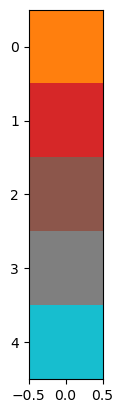

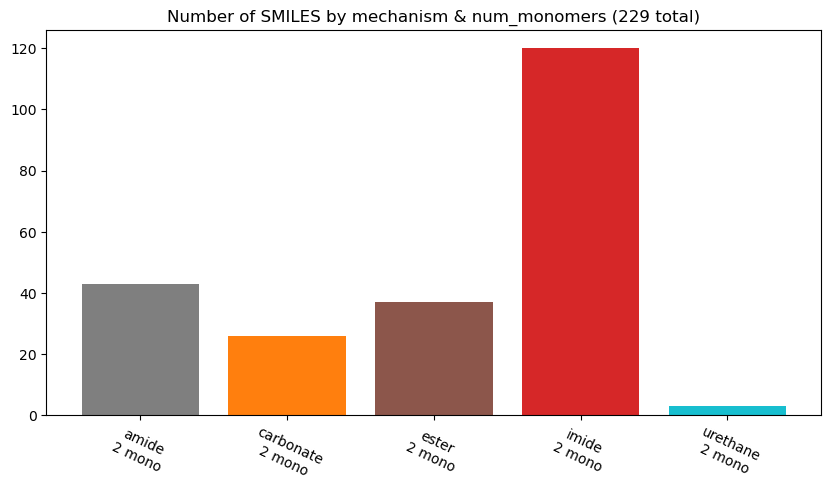

In [50]:
plt.imshow(carr)

plotutils.presize_subplots(1, 1, scale=10, elongation=1/2)

plt.bar(plot_counts.keys(), plot_counts.values(), color=colors)
plt.xticks(np.arange(len(counts))+0, rotation=-25)

plt.title(f'Number of SMILES by {" & ".join(keys)} ({len(df)} total)')

# Visually inspecting monomer and oligomer units

In [ ]:
from polymerist.monomers import specification

mech = 'ester'
# mech = 'carbonate'
# mech = 'urethane'
# mech = 'vinyl'
# mech = 'imide'

# ids = (23, 223)
ids = ()
n = 10

spacer = '=' * 25
frame = frames[mech]

test = defaultdict(list)
smaller = set()
for idx, row in frame.head(n).iterrows():
    if (not ids) or (idx in ids):
        # extract and visualize structures
        print(f'\n{spacer} {row["mechanism"]}-{idx} {spacer}\n')
        monomer_smiles = row['smiles_monomer']
        monomer_smiles = specification.expanded_SMILES(monomer_smiles, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(monomer_smiles, sanitize=False)
        display(monomer)

        # dimer_smiles  = row['smiles_polymer_DP2']
        # dimer = Chem.MolFromSmiles(dimer_smiles)
        # display(dimer)

        # trimer_smiles = row['smiles_polymer_DP3']
        # trimer = Chem.MolFromSmiles(trimer_smiles)
        # display(trimer)

        # other info

        num_monos = row['num_monomers']
        frags = Chem.GetMolFrags(monomer, asMols=True)
        count_monos = len(frags)
        assert(num_monos == count_monos) # sanity check

        for frag in frags:
            pcquery = pcp.get_compounds(Chem.MolToSmiles(frag), namespace='smiles')
            pccomp = pcquery.pop()
            print(pccomp.iupac_name)

        test[count_monos].append(monomer)

# Testing Reactions

In [ ]:
p =  PROC_DATA_DIR / '20231114_polyid_data_density_FILTERED.csv'
df2 = pd.read_csv(p, index_col=0)
df2

In [89]:
keys = ['mechanism']
df_grouper = df2.groupby(keys)
frames = {
    mech : df_grouper.get_group(mech)
        for mech in df_grouper.groups
}

In [90]:
frame = frames['ester']
frame.index

Index([ 22,  36,  66, 106, 111, 115, 135, 171, 177, 189, 205, 206, 216, 218,
       226, 232, 237, 250, 257, 262, 296, 306, 314, 315, 330, 363, 365, 371,
       381, 382, 396, 409, 412, 420, 443, 454, 463],
      dtype='int64')

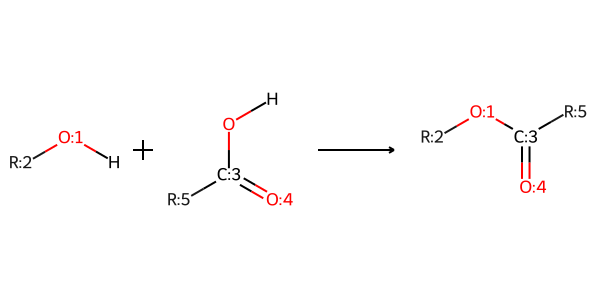

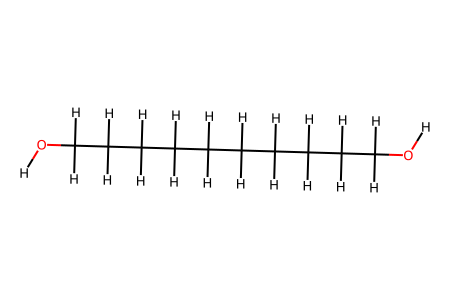

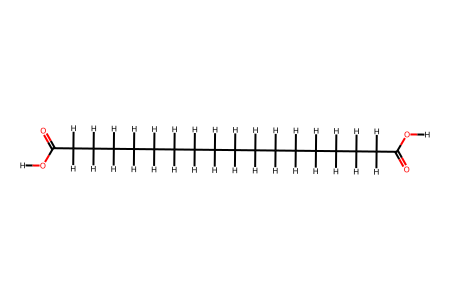

In [91]:
row = frame.loc[36]
rxn = rxns[rxn_backmap[row['mechanism']]]
display(rxn)

keys = ['smiles_expanded_monomer_1', 'smiles_expanded_monomer_2']
reactants = []
for key in keys:
    mol = Chem.MolFromSmiles(row[key], sanitize=False)
    display(mol)
    reactants.append(mol)

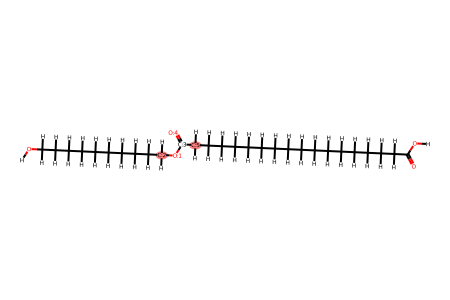

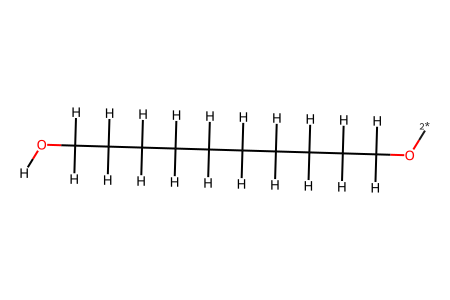

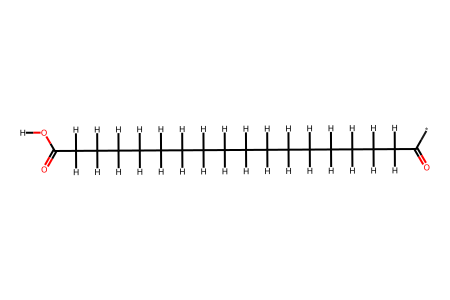

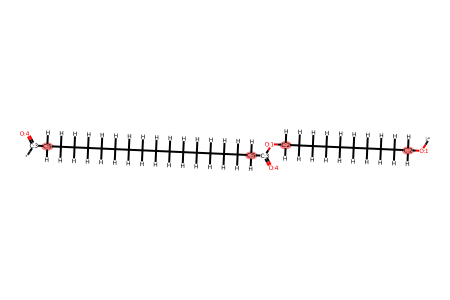

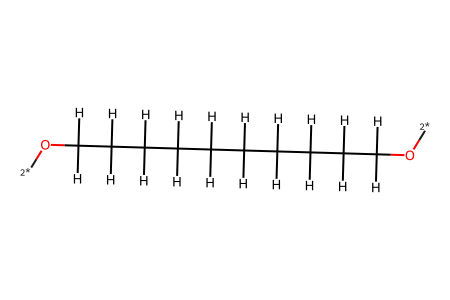

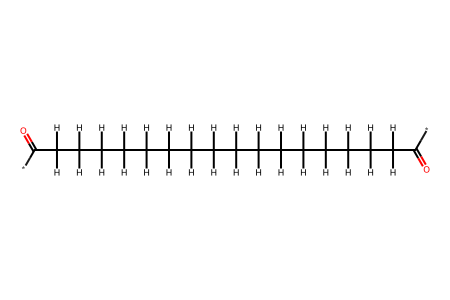

In [92]:
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn)
for dimer, frags in reactor.propagate(reactants):
    display(dimer)
    for frag in frags:
        display(frag)

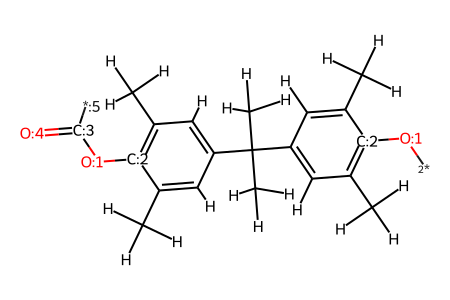

In [83]:
reactor.react(frags)

# Preprocessing and cleaning up NREL Urethane data

## Loading and inspecting raw data

In [ ]:
p = RAW_DATA_DIR / 'nipu_urethanes.xlsx'
raw_table = pd.read_excel(p) # load from .xlsx file
raw_table['Monomers'] = raw_table['Monomers'].apply(literal_eval) # convert string of tuples into proper tuples

nipus     = raw_table[raw_table['Chemistry'] == 'NIPU'    ]
urethanes = raw_table[raw_table['Chemistry'] == 'urethane']

nipus_mono     = nipus['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order
urethanes_mono = urethanes['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order

In [ ]:
raw_table

In [ ]:
# targ_mono = nipus_mono
targ_mono = {}

for i, monos in targ_mono.items():
    try:
        mono1, mono2 = monos
        display(Chem.MolFromSmiles(mono1))
        
        print('='*50)
    except ValueError:
        print(f'Row {i} failed')

## Classify each monomer pair by respective reactive functional group

In [ ]:
with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as fn_group_file:
    fn_group_SMARTS = json.load(fn_group_file)
    fn_groups = {
        group_name : Chem.MolFromSmarts(SMARTS)
            for group_name, SMARTS in fn_group_SMARTS.items()
    }

reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

all_results = []
digroup_only_results = []
for i, (chemistry, monomer_pair) in raw_table.iterrows():
    monomer_entry = {
        'Chemistry' : chemistry
    }

    too_many_sites = False
    for SMILES in monomer_pair:
        rdmol = Chem.MolFromSmiles(SMILES)
        rdmol = Chem.AddHs(rdmol)
        Chem.Kekulize(rdmol, clearAromaticFlags=True) # ensure aromatic rings are treated as simply single-double (simplifies structure matching)

        for group_name, fn_group in fn_groups.items():
            matches = rdmol.GetSubstructMatches(fn_group)
            if matches and (group_name in reaction_pairs[chemistry]):
                monomer_entry[group_name] = Chem.MolToSmarts(rdmol)
            too_many_sites |= (len(matches) > 2) # OR with previous result; single true will make result true
        
    all_results.append(monomer_entry)
    if not too_many_sites:        
        digroup_only_results.append(monomer_entry)

## Save to csv files for future reference

In [ ]:
all_table = pd.DataFrame.from_records(all_results)
digroup_only_table = pd.DataFrame.from_records(digroup_only_results)

all_table.to_csv(PROC_DATA_DIR / 'clean_smarts_all.csv')
digroup_only_table.to_csv(PROC_DATA_DIR / 'clean_smarts_digroup.csv')